# WT vs loop

In [1]:
library(sleuth)
library(splines)
library(scales)

Loading required package: ggplot2
Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
#https://stackoverflow.com/questions/41849951/using-ggplot-geo-geom-histogram-with-y-log-scale-with-zero-bins
mylog10_trans <- function (base = 10) 
{
  trans <- function(x) log(x + 1, base)
  inv <- function(x) base^x
  trans_new(paste0("log-", format(base)), trans, inv, log_breaks(base = base), 
            domain = c(1e-100, Inf))
}

In [3]:
d=read.delim("../kallisto/sample_descriptions/our_data.txt",sep="\t",stringsAsFactors=FALSE)
names(d)[1:2]=c("sample","sample_alias")
d$batch=as.numeric(gsub("^[^-]+-[^-]+-[^-]+-(\\d+$)$","\\1",gsub("([A-z]+)(\\d+)","\\1-\\2",d$sample,perl=TRUE),perl=TRUE))
d$batch[is.na(d$batch)]=1
table(d$batch)
d$harvest=sprintf("%id_b%i",d$Time,d$batch)
table(d$harvest)
head(d)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


 1  2  3 
24 25 25 


12d_b1 12d_b2 12d_b3 14d_b1 14d_b2 14d_b3  3d_b1  3d_b2  3d_b3  5d_b1  5d_b2 
     5      5      5      5      5      5      4      5      5      5      5 
 5d_b3  9d_b1  9d_b2  9d_b3 
     5      5      5      5 

sample,sample_alias,Group,GT,Time,elongation_caulonema,protonemata_branching,number_buds_per_filament,percents_filaments_with_buds,gametophore_formation,colony_size,rhizoid_formation,development_of_phyllids,batch,harvest
1-W3,1.W3,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,1,3d_b1
2-W3-2,2.W3.2,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,2,3d_b2
3-W3-3,3.W3.3,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,3,3d_b3
4-D3,4.D3,2,deltaDEK,3,normal,normal,absent,absent,absent,normal,absent,absent,1,3d_b1
5-D3-2,5.D3.2,2,deltaDEK,3,normal,normal,absent,absent,absent,normal,absent,absent,2,3d_b2
6-D3-3,6.D3.3,2,deltaDEK,3,normal,normal,absent,absent,absent,normal,absent,absent,3,3d_b3


In [4]:
#outlier replicates
exclude=d$sample[grep("5-3$",d$sample,perl=TRUE)]

In [5]:
d=subset(d,! sample %in% exclude )

In [6]:
table(d$GT,d$Time)

          
           3 5 9 12 14
  deltaDEK 3 2 3  3  3
  LG3      3 2 3  3  3
  Loop     3 2 3  3  3
  OE       2 2 3  3  3
  WT       3 2 3  3  3

In [7]:
table(file.exists(sprintf("../kallisto/kallisto/%s/abundance.h5",d$sample)))


TRUE 
  69 

In [8]:
d$path=sprintf("../kallisto/kallisto/%s/abundance.h5",d$sample)

In [9]:
m=read.delim("../analysis/cosmoss_V3.3.mRNA_ncRNA.tx2gene.full.tsv",stringsAsFactors=FALSE)
names(m)[1]="target_id"
m$class=ifelse(is.na(m$class),m$TYPE,m$class)
m$gene=paste(m$GENEID,m$class,sep=".")
m=m[,c("target_id","gene","class","TYPE")]
nrow(m)
head(m)

[1] 93962

target_id,gene,class,TYPE
Pp3c1_20V3.1,Pp3c1_20.mRNA,mRNA,mRNA
Pp3c1_20V3.2,Pp3c1_20.mRNA,mRNA,mRNA
Pp3c1_40V3.2,Pp3c1_40.mRNA,mRNA,mRNA
Pp3c1_40V3.1,Pp3c1_40.mRNA,mRNA,mRNA
Pp3c1_50V3.2,Pp3c1_50.mRNA,mRNA,mRNA
Pp3c1_50V3.1,Pp3c1_50.mRNA,mRNA,mRNA


In [10]:
D=droplevels(subset(d, GT %in% c("WT","Loop")))
head(D)
table(D$GT,D$Time)

,sample,sample_alias,Group,GT,Time,elongation_caulonema,protonemata_branching,number_buds_per_filament,percents_filaments_with_buds,gametophore_formation,colony_size,rhizoid_formation,development_of_phyllids,batch,harvest,path
1,1-W3,1.W3,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,1,3d_b1,../kallisto/kallisto/1-W3/abundance.h5
2,2-W3-2,2.W3.2,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,2,3d_b2,../kallisto/kallisto/2-W3-2/abundance.h5
3,3-W3-3,3.W3.3,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,3,3d_b3,../kallisto/kallisto/3-W3-3/abundance.h5
7,7-LO3,7.LO3,3,Loop,3,normal,normal,absent,absent,absent,normal,absent,absent,1,3d_b1,../kallisto/kallisto/7-LO3/abundance.h5
8,8-LO3-2,8.LO3.2,3,Loop,3,normal,normal,absent,absent,absent,normal,absent,absent,2,3d_b2,../kallisto/kallisto/8-LO3-2/abundance.h5
9,9-LO3-3,9.LO3.3,3,Loop,3,normal,normal,absent,absent,absent,normal,absent,absent,3,3d_b3,../kallisto/kallisto/9-LO3-3/abundance.h5


      
       3 5 9 12 14
  Loop 3 2 3  3  3
  WT   3 2 3  3  3

In [11]:
so.D=sleuth_prep(D, target_mapping = m,aggregation_column = 'gene', extra_bootstrap_summary = TRUE)

reading in kallisto results
dropping unused factor levels
............................
normalizing est_counts
45279 targets passed the filter
normalizing tpm
merging in metadata
aggregating by column: gene
21799 genes passed the filter
Warning message in sleuth_prep(D, target_mapping = m, aggregation_column = "gene", :
“2 target_ids are missing annotations for the aggregation_column: gene.
These target_ids will be dropped from the gene-level analysis.
If you did not expect this, check your 'target_mapping' table for missing values.”summarizing bootstraps



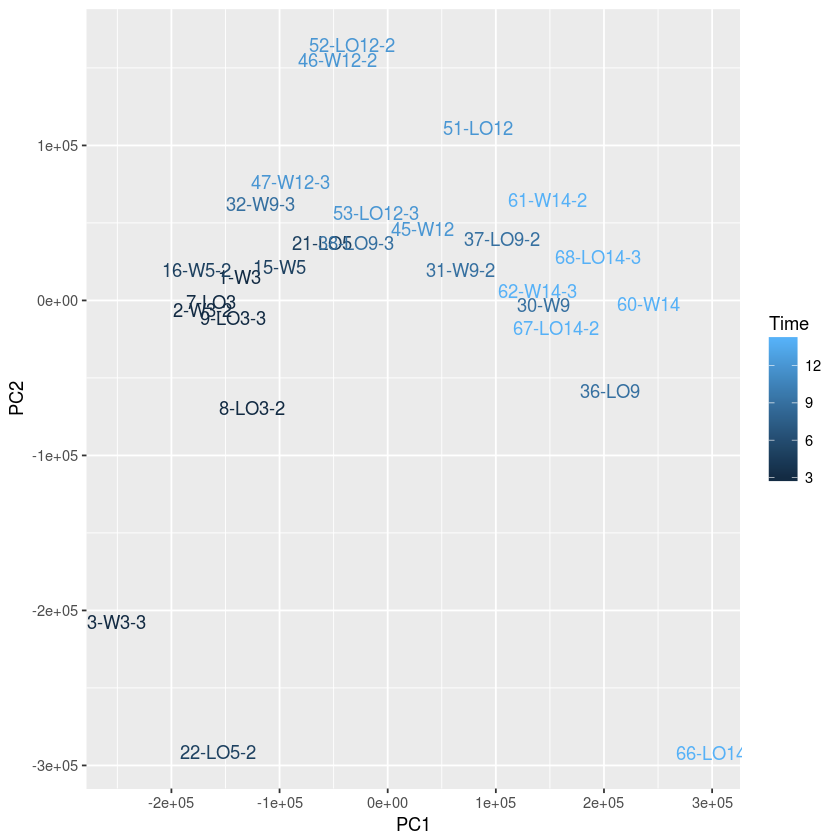

In [12]:
plot_pca(so.D, color_by = 'Time',text_labels = TRUE,units='scaled_reads_per_base')

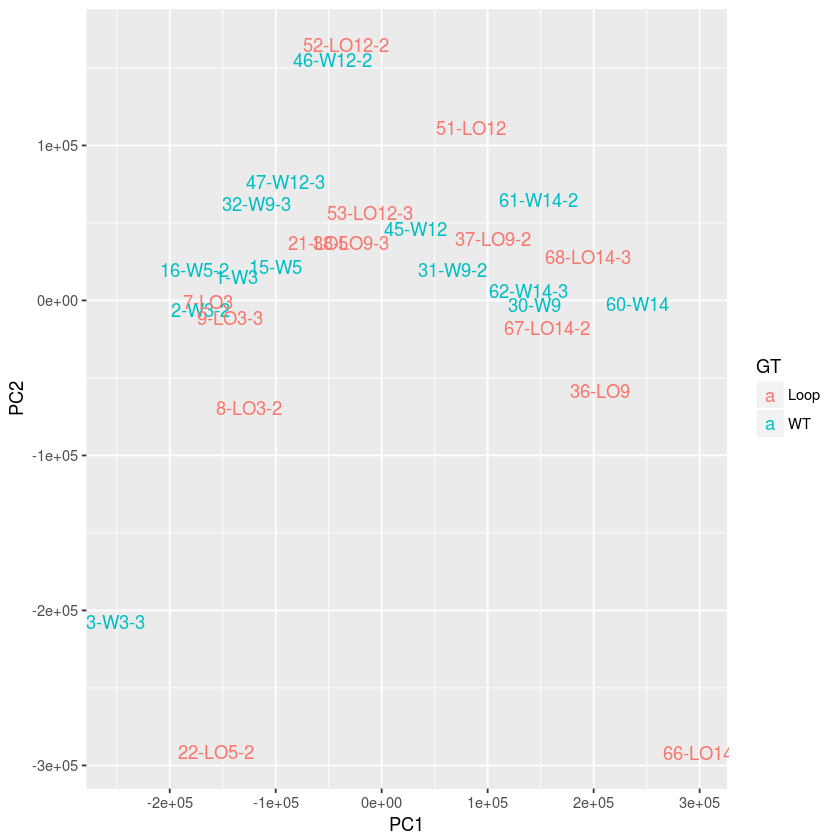

In [13]:
plot_pca(so.D, color_by = 'GT',text_labels = TRUE,units='scaled_reads_per_base')

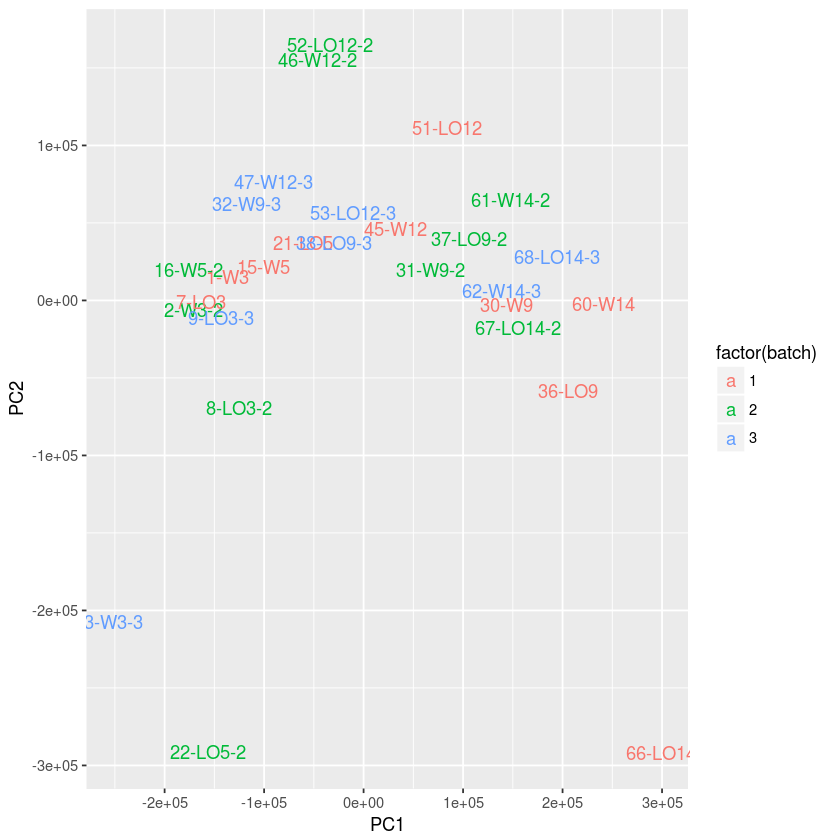

In [14]:
plot_pca(so.D, color_by = 'factor(batch)',text_labels = TRUE,units='scaled_reads_per_base',use_filtered=TRUE)

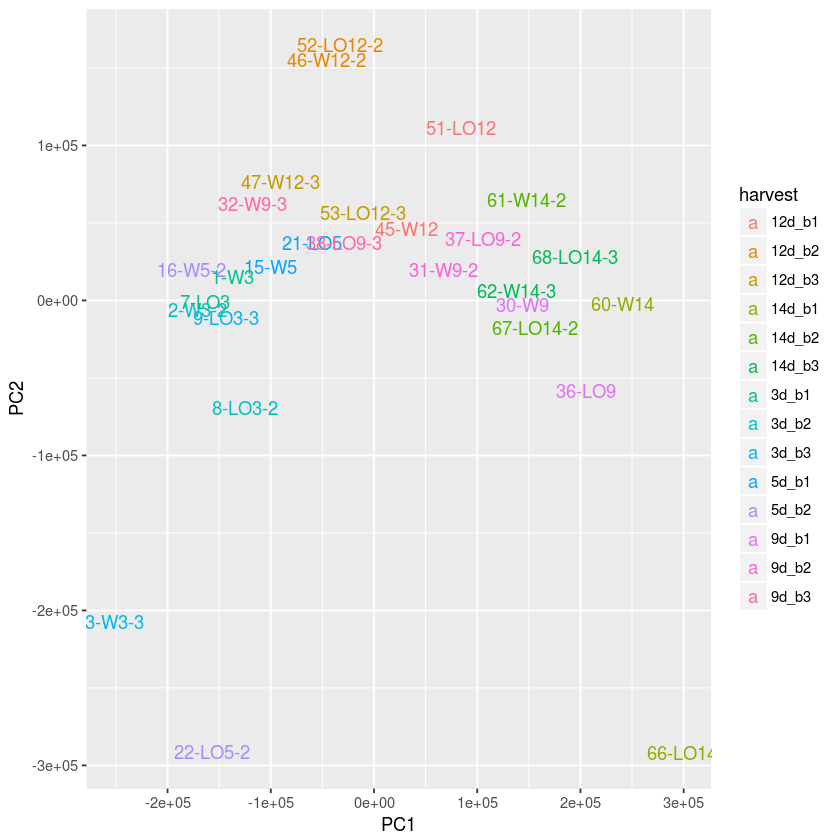

In [15]:
plot_pca(so.D, color_by = 'harvest',text_labels = TRUE,units='scaled_reads_per_base',use_filtered=TRUE)

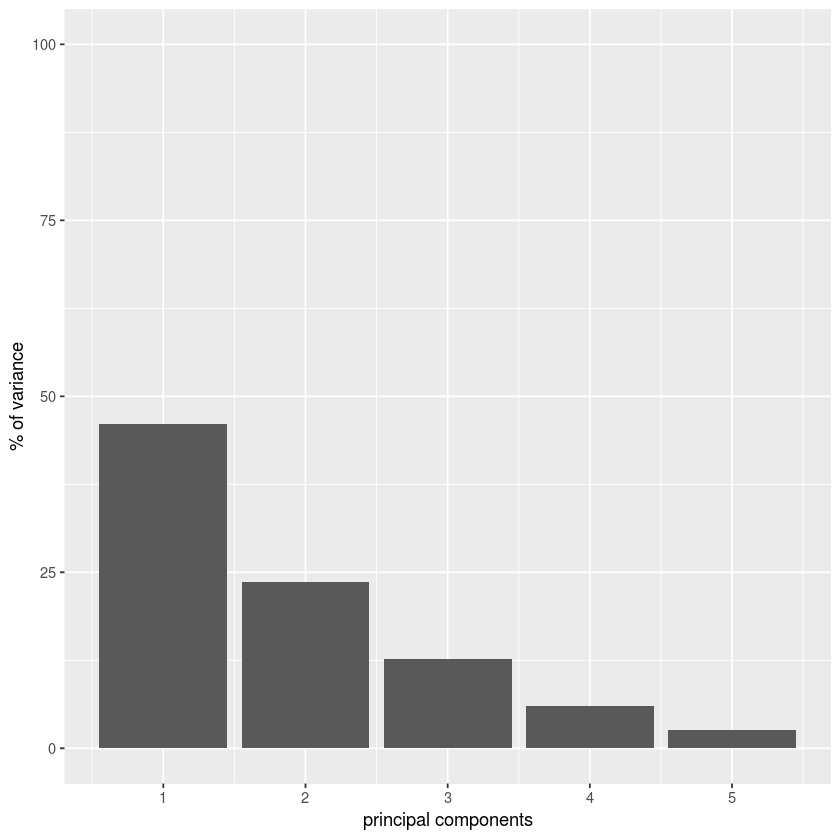

In [16]:
plot_pc_variance(so.D,units='scaled_reads_per_base')

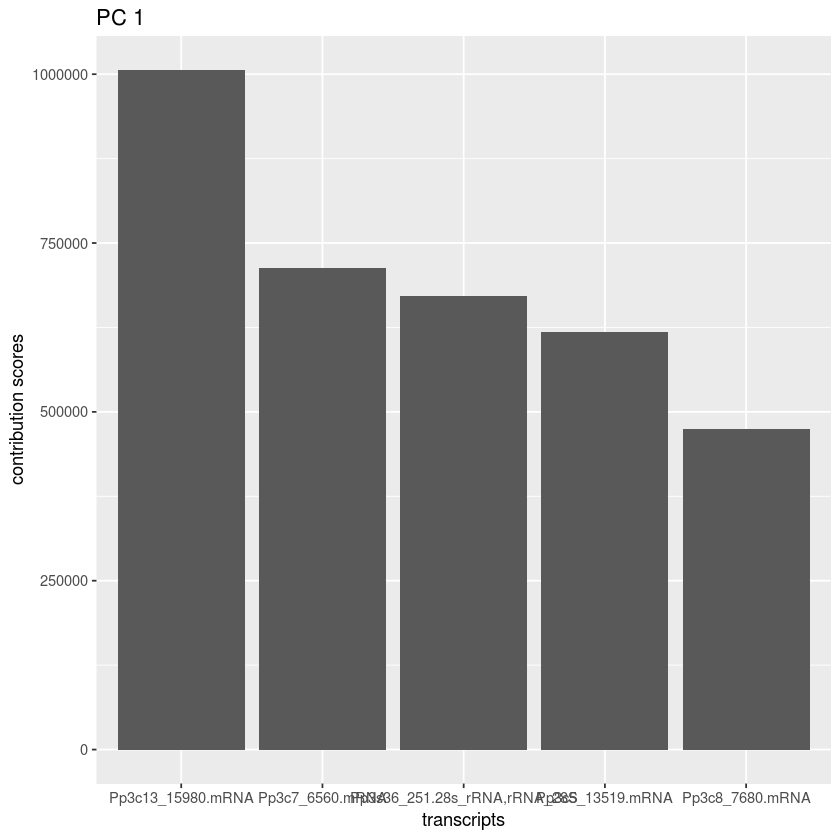

In [17]:
plot_loadings(so.D, pc_input = 1,units='scaled_reads_per_base')

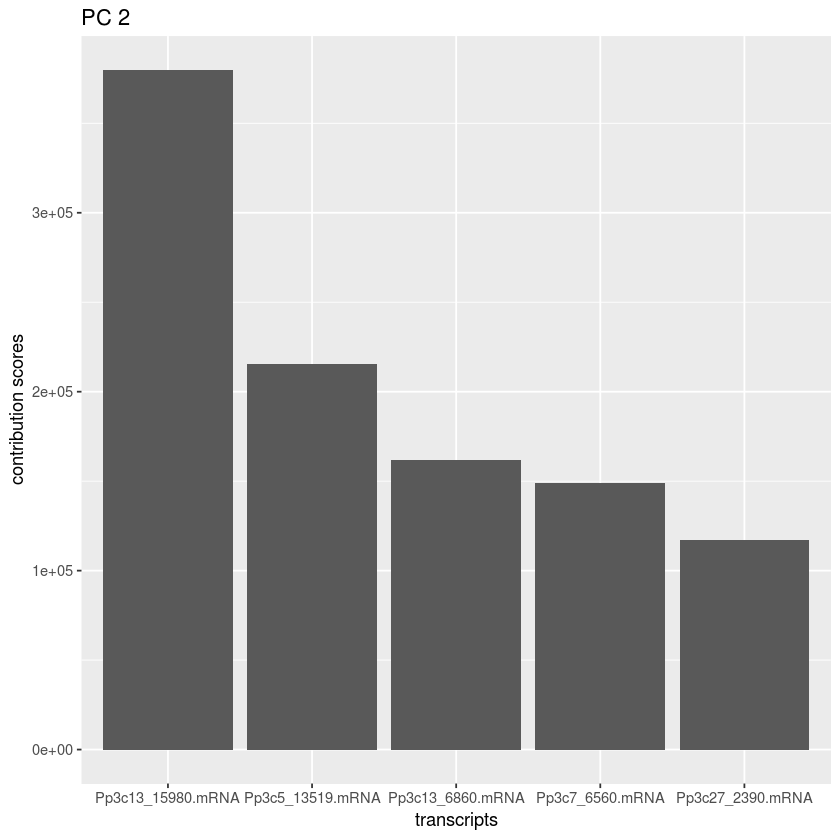

In [18]:
plot_loadings(so.D, pc_input = 2,units='scaled_reads_per_base')

Warning message:
“'switch' is deprecated.
Use 'strip.position' instead.
See help("Deprecated")”

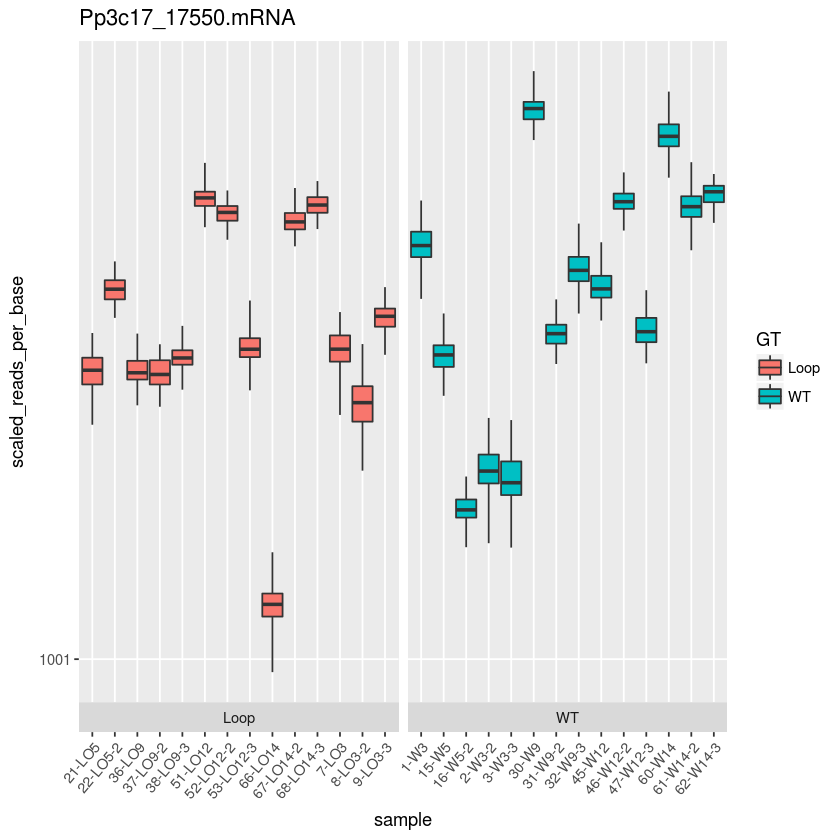

In [19]:
plot_bootstrap(so.D, 'Pp3c17_17550.mRNA', color_by = 'GT',units='scaled_reads_per_base') + scale_y_continuous(trans = "mylog10")

Warning message:
“'switch' is deprecated.
Use 'strip.position' instead.
See help("Deprecated")”

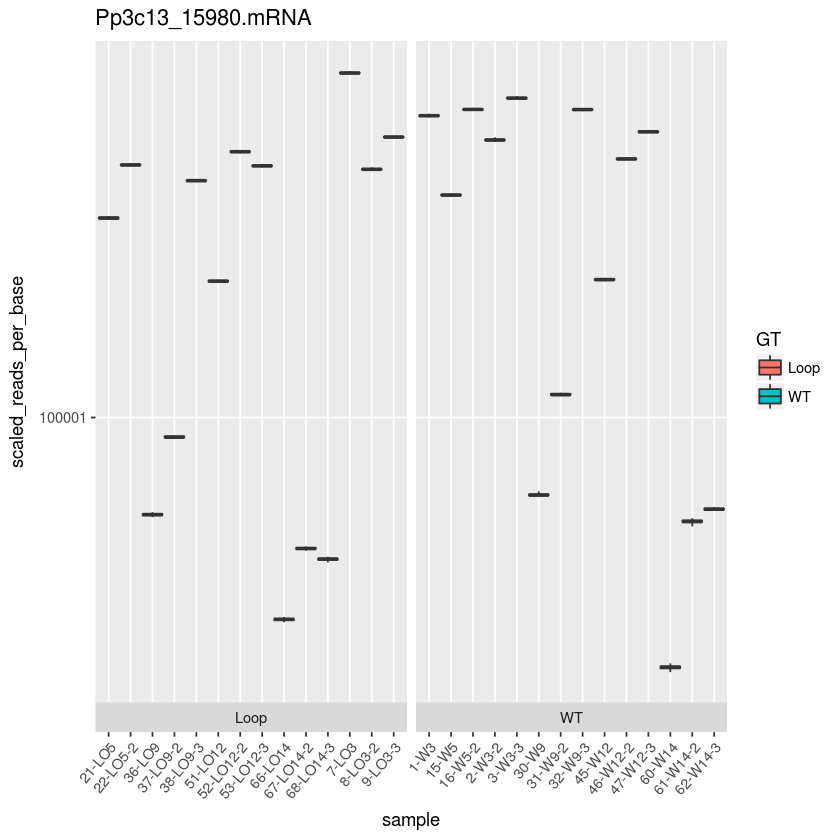

In [20]:
plot_bootstrap(so.D, 'Pp3c13_15980.mRNA', color_by = 'GT',units='scaled_reads_per_base') + scale_y_continuous(trans = "mylog10")

In [21]:
D$GT=relevel(factor(D$GT),"WT")

In [22]:
full_design <- model.matrix(formula(~ GT + ns(Time, df = 4)),data=D)
reduced_design <- model.matrix(formula(~ ns(Time, df = 4)),data=D)

In [23]:
full_design2 <- model.matrix(formula(~ GT + factor(batch) + ns(Time, df = 4)),data=D)
reduced_design2 <- model.matrix(formula(~ factor(batch) + ns(Time, df = 4)),data=D)

In [24]:
full_design2

,(Intercept),GTLoop,factor(batch)2,factor(batch)3,"ns(Time, df = 4)1","ns(Time, df = 4)2","ns(Time, df = 4)3","ns(Time, df = 4)4"
1,1,0,0,0,0.00000000,0.0000000,0.0000000,0.00000000
2,1,0,1,0,0.00000000,0.0000000,0.0000000,0.00000000
3,1,0,0,1,0.00000000,0.0000000,0.0000000,0.00000000
7,1,1,0,0,0.00000000,0.0000000,0.0000000,0.00000000
8,1,1,1,0,0.00000000,0.0000000,0.0000000,0.00000000
9,1,1,0,1,0.00000000,0.0000000,0.0000000,0.00000000
15,1,0,0,0,0.07407407,-0.1301890,0.4556617,-0.32547261
16,1,0,1,0,0.07407407,-0.1301890,0.4556617,-0.32547261
21,1,1,0,0,0.07407407,-0.1301890,0.4556617,-0.32547261
22,1,1,1,0,0.07407407,-0.1301890,0.4556617,-0.32547261


In [25]:
so.D= sleuth_fit(so.D,reduced_design2,fit_name="reduced2")

fitting measurement error models
shrinkage estimation
computing variance of betas


In [26]:
so.D= sleuth_fit(so.D, full_design2, fit_name = "full2")

fitting measurement error models
shrinkage estimation
computing variance of betas


In [27]:
so.D = sleuth_lrt(so.D, "reduced2", "full2")

In [28]:
models(so.D)

[  reduced2  ]
formula:  structure(c(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,  1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,  0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,  0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,  1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0.0740740740740741, 0.0740740740740741,  0.0740740740740741, 0.0740740740740741, 0.603174603174603, 0.603174603174603,  0.603174603174603, 0.603174603174603, 0.603174603174603, 0.603174603174603,  0.0888888888888889, 0.0888888888888889, 0.0888888888888889, 0.0888888888888889,  0.0888888888888889, 0.0888888888888889, 0, 0, 0, 0, 0, 0, 0,  0, 0, 0, 0, 0, -0.130189045660703, -0.130189045660703, -0.130189045660703,  -0.130189045660703, 0.209559381722464, 0.209559381722464, 0.209559381722464,  0.209559381722464, 0.209559381722464, 0.209559381722464, 0.587464387464387,  0.587464387464387, 0.587464387464387, 0.587464387464387, 0.587464387464387,  0.587464387464387, -0.128205128205128, -0

In [29]:
so.D = sleuth_wt(so.D, 'GTLoop', which_model = "full2")

Warning message:
“Removed 8 rows containing missing values (geom_point).”

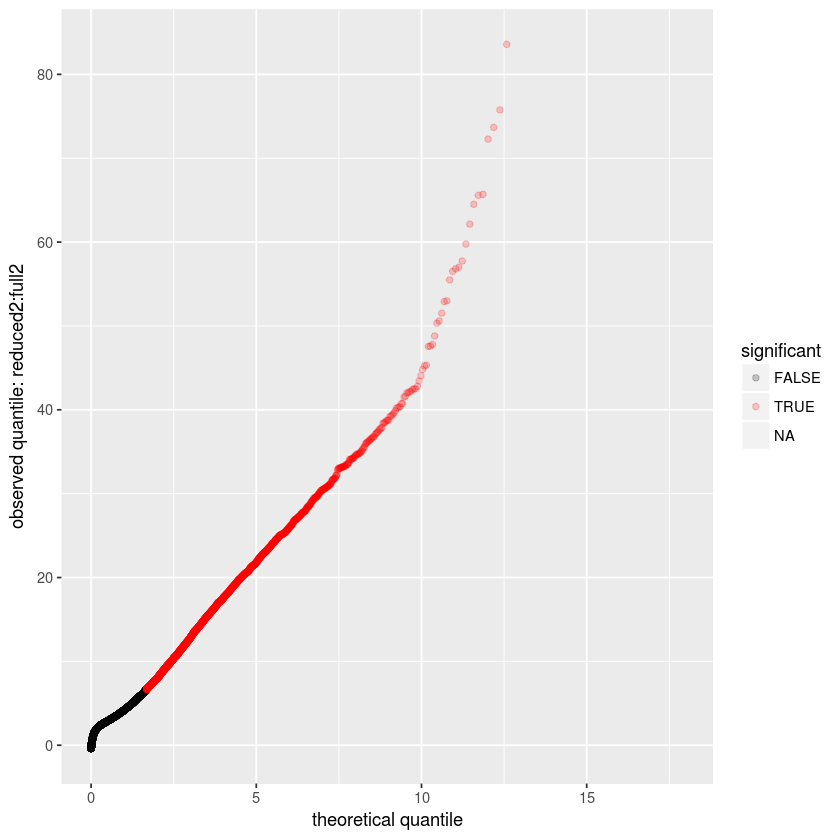

In [30]:
plot_qq(so.D, test = 'reduced2:full2', test_type = 'lrt', sig_level = 0.05)

Warning message:
“Removed 8 rows containing missing values (geom_path).”

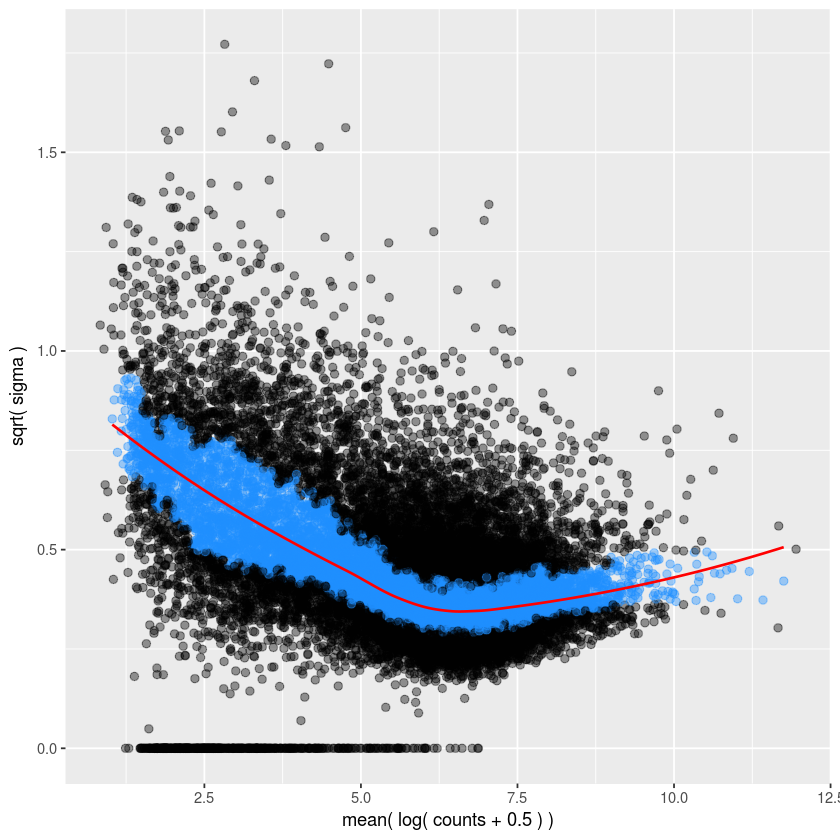

In [31]:
plot_mean_var(so.D,which_model="full2")

In [32]:
tt=sleuth_results(so.D,'GTLoop','wt',which_model="full2" ,show_all = FALSE,rename_cols=FALSE)
tt.sig= dplyr::filter(tt, qval < 0.05)
nrow(tt.sig)
table(tt.sig$b>0)

[1] 3317


FALSE  TRUE 
 1476  1841 

In [33]:
lrt_results= sleuth_results(so.D, 'reduced2:full2', test_type = 'lrt',show_all=TRUE)

In [34]:
o=na.omit(merge(lrt_results,tt,by="target_id",suffixes=c(".lrt",".wt")))
o=o[order(-o$b,-o$test_stat),]
table(o$b>0)
head(o[o$b>0,])


FALSE  TRUE 
10762 11029 

,target_id,test_stat,pval.lrt,qval.lrt,rss,sigma_sq.lrt,tech_var,mean_obs.lrt,var_obs.lrt,sigma_sq_pmax,⋯,pval.wt,qval.wt,b,se_b,mean_obs.wt,var_obs.wt,sigma_q_sq,sigma_sq.wt,smooth_sigma_sq.wt,smooth_sigma_sq_pmax
21663,Pp3s51_30.mRNA,28.63536,8.737212e-08,8.938620e-06,203.27880,8.254800,1.42514267,2.344792,9.627049,8.254800,⋯,1.652740e-09,1.765434e-07,4.328051,0.7179067,2.344792,9.627049,1.42514267,2.1825878,0.19595613,2.1825878
6451,Pp3c16_14660.mRNA,14.24057,1.608650e-04,2.305678e-03,224.00290,9.314794,1.35201043,3.800517,9.006198,9.314794,⋯,2.148318e-04,3.106436e-03,3.606551,0.9745051,3.800517,9.006198,1.35201043,5.2956111,0.07736574,5.2956111
15709,Pp3c3_29560.mRNA,20.55830,5.784239e-06,1.933196e-04,137.10997,5.535857,0.99318978,3.085170,8.669032,5.535857,⋯,2.423850e-06,8.410527e-05,3.210891,0.6810769,3.085170,8.669032,0.99318978,2.2538706,0.12267212,2.2538706
2999,Pp3c11_7530.mRNA,64.50614,9.623180e-16,2.995696e-12,64.04939,2.944658,0.10531295,4.769219,5.858508,2.944658,⋯,1.141090e-41,3.552213e-38,2.871915,0.2123696,4.769219,5.858508,0.10531295,0.2103928,0.03996905,0.2103928
2881,Pp3c11_3860.mRNA,44.05240,3.197015e-11,2.580228e-08,67.14892,3.016913,0.18065524,5.646166,5.500484,3.016913,⋯,1.187216e-18,9.581715e-16,2.762137,0.3133130,5.646166,5.500484,0.18065524,0.5064998,0.01983419,0.5064998
17014,Pp3c4_4250.mRNA,56.52192,5.557524e-14,9.315692e-11,49.14081,2.298901,0.04113816,4.109097,3.689149,2.298901,⋯,1.137988e-30,2.066491e-27,2.469758,0.2145239,4.109097,3.689149,0.04113816,0.2810053,0.06304491,0.2810053


In [35]:
m1=read.delim("../analysis//cosmoss_V3.3.mRNA_ncRNA.tx2gene.full.gene_wise.tsv",sep="\t",stringsAsFactors=FALSE)
names(m1)[1]="target_id"
head(m1)

target_id,spectype,TXNAME,GENEID,TYPE,Alias,support,origin,isoform,longest_transcript,has_evidence,class,has_protein_homology,has_proteomics_support,encoded_by,is_filtered
Pp3c10_10000.tRNA,tRNA,Pp3c10_10000V3.1,Pp3c10_10000,ncRNA,"tRNA,Pp3c10_10000N1.1,Pp3c10_10000V1.1,N1.Chr10.ncRNA.54,tRNA.717",supported_by_sequence_similarity,RFAM11.Infernal1.1,major,true,false,tRNA,false,false,ncRNA_gene,false
Pp3c10_10040.mRNA,mRNA,"Pp3c10_10040V3.2,Pp3c10_10040V3.3,Pp3c10_10040V3.5,Pp3c10_10040V3.6,Pp3c10_10040V3.4,Pp3c10_10040V3.1",Pp3c10_10040,mRNA,"PAC4GC:5701563,Pp3c10_10040J4.1,Pp1s58_283V6.2,PAC4GC:5701564,P2.evm.model.Chr10.357,Pp3c10_10040J5.3,Pp3c10_10040J5.4,Pp3c10_10040V1.1,P2.Chr10.mRNA.3452,Phpatv32029367m,PAC4GC:5701565,Phpatv32029366m,PAC4GC:5701561,Pp3c10_10040J5.2,Pp1s58_283V6.1,Pp3c10_10040J5.1,Phpatv32029364m,Pp3c10_10040P2.1,Phpatv32029365m,Phpatv32029363m,P2.EVM%20prediction%20Chr10.357,Pp3c10_10040P2.2,PAC4GC:5701562",supported_by_EST_or_cDNA,NA,"alternative,major","true,false",true,NA,true,false,protein_coding_gene,false
Pp3c10_10090.mRNA,mRNA,"Pp3c10_10090V3.2,Pp3c10_10090V3.1",Pp3c10_10090,mRNA,"Phpatv32029368m,Pp3c10_10090V1.1,J3.Chr10.mRNA.912,J3.Phypav3.0.4_pg25522.valid.m1,J3.7022241,Pp3c10_10090J4.1,Pp3c10_10090J3.1,PAC4GC:5700224,pred.234120000946",supported_by_EST_or_cDNA,NA,"major,alternative","false,true",true,NA,false,false,protein_coding_gene,false
Pp3c10_10095.C_D_box_snoRNA,C_D_box_snoRNA,Pp3c10_10095V3.1,Pp3c10_10095,ncRNA,"Chr10.snoRNA.21,snoR64.1,Chr10.snoRNA.22,Pp3c10_10095V1.1,Chr10.snoRNA.32,Chr10.snoRNA.23,snoR64,N1.Chr10.ncRNA.55,Pp3c10_10095N1.1,Chr10.snoRNA.33,snR72%2FZ2,snR58",supported_by_sequence_similarity,"RFAM11.Infernal1.1,snoscan-0.9b",major,true,true,C_D_box_snoRNA,false,false,ncRNA_gene,false
Pp3c10_100.ncRNA,ncRNA,Pp3c10_100V3.1,Pp3c10_100,ncRNA,"Pp3c10_100V1.1,Pp3c10_100P0.1,asmbl_110854",supported_by_EST_or_cDNA,NA,major,true,true,NA,false,false,ncRNA_gene,false
Pp3c10_10100.mRNA,mRNA,"Pp3c10_10100V3.1,Pp3c10_10100V3.4,Pp3c10_10100V3.2,Pp3c10_10100V3.5,Pp3c10_10100V3.3",Pp3c10_10100,mRNA,"Pp3c10_10100J5.3,Phpatv32029369m,PAC4GC:5701591,PAC4GC:5701593,Pp1s58_289V6.1_29440,PAC4GC:5701592,Phpatv32029370m,Pp3c10_10100V1.1,Phpatv32029372m,Pp3c10_10100J5.1,Pp3c10_10100J5.2,C1.Pp1s58_289V6.1,Phpatv32029371m,C1.560145,PAC4GC:5701590,Pp1s58_289V6.1,C1.Chr10.mRNA.576,Pp3c10_10100J4.1,Pp3c10_10100C1.1",supported_by_EST_or_cDNA,NA,"alternative,major","true,false",true,NA,true,false,protein_coding_gene,false


In [36]:
m2=read.delim("../analysis//cosmoss.genonaut.V3.3.gene_and_protein_names.tsv",sep="\t",col.names=c("GENEID","name"),stringsAsFactors=FALSE)
head(m2)

GENEID,name
Pp3c10_13310,XTH28
Pp3c10_13800,"CHR1545,chr1545"
Pp3c10_13960,"CHLH1,chlh2,CHLH2,chlh1"
Pp3c10_13970,"chlh1,CHLH2,chlh2,CHLH1"
Pp3c10_14020,"raba53,RABA53"
Pp3c10_14800,"ppr_20,PPR_20"


In [37]:
m3=read.delim("../analysis//Ppatens_318_v3.3.defline.txt",sep="\t",col.names=c("GENEID","source","defline"),stringsAsFactors=FALSE)
m3$GENEID=gsub("V3\\.\\d+","",m3$GENEID,perl=TRUE)
head(m3)

GENEID,source,defline
Pp3c10_10220,pdef,"K00615 - transketolase (E2.2.1.1, tktA, tktB) (1 of 4)"
Pp3c10_10230,pdef,K14763 - H/ACA ribonucleoprotein complex non-core subunit NAF1 (NAF1) (1 of 1)
Pp3c10_10240,pdef,PTHR10641:SF599 - MYB TRANSCRIPTION FACTOR-RELATED (1 of 3)
Pp3c10_10270,pdef,2.4.1.12 - Cellulose synthase (UDP-forming) / UDP-glucose-cellulose glucosyltransferase (1 of 17)
Pp3c10_10460,pdef,"K03320 - ammonium transporter, Amt family (amt, AMT, MEP) (1 of 12)"
Pp3c10_10490,pdef,"PTHR11177:SF167 - RHODANESE-LIKE DOMAIN-CONTAINING PROTEIN 4, CHLOROPLASTIC (1 of 3)"


In [38]:
m4=read.delim("../analysis//Physcomitrella_patens.TAP_annotation.6.tsv",sep="\t")
names(m4)[2]="GENEID"
head(m4)

superfamily,GENEID,inferred_by_rule,TAP_class
BSD domain containing,Pp3c11_12590V3,True,PT
BSD domain containing,Pp3c1_21290V3,True,PT
BSD domain containing,Pp3c20_12230V3,True,PT
BSD domain containing,Pp3c23_10600V3,True,PT
BSD domain containing,Pp3c24_7080V3,True,PT
BSD domain containing,Pp3c26_14480V3,True,PT


In [39]:
O=merge(o,m1,by="target_id")
nrow(o)
nrow(O)
O=merge(O,m2,by="GENEID",all.x=TRUE)
nrow(O)
O=merge(O,m3,by="GENEID",all.x=TRUE)
nrow(O)
O=merge(O,m4,by="GENEID",all.x=TRUE)
nrow(O)
O=O[order(-O$test_stat),]
head(O)

[1] 21791

[1] 21791

[1] 21791

[1] 21791

[1] 21791

,GENEID,target_id,test_stat,pval.lrt,qval.lrt,rss,sigma_sq.lrt,tech_var,mean_obs.lrt,var_obs.lrt,⋯,has_protein_homology,has_proteomics_support,encoded_by,is_filtered,name,source,defline,superfamily,inferred_by_rule,TAP_class
11742,Pp3c21_8110,Pp3c21_8110.mRNA,83.58227,6.111887e-20,1.331841e-15,32.639587,1.5057016,0.0485644185,5.107251,2.3970680,⋯,true,false,protein_coding_gene,false,NA,NA,NA,NA,NA,NA
2996,Pp3c11_7360,Pp3c11_7360.mRNA,75.77182,3.184136e-18,3.469276e-14,42.774731,1.9324005,0.1044914877,3.763677,4.6412112,⋯,true,false,protein_coding_gene,false,NA,pdef,PF14368 - Probable lipid transfer (LTP_2) (1 of 63),NA,NA,NA
21618,Pp3s406_20,Pp3s406_20.mRNA,73.67706,9.200171e-18,6.682698e-14,44.196587,2.0440371,0.0605622606,5.933522,3.8960716,⋯,true,false,protein_coding_gene,false,NA,NA,NA,NA,NA,NA
16870,Pp3c4_28500,Pp3c4_28500.mRNA,72.27813,1.869072e-17,1.018223e-13,4.327988,0.2058269,0.0002677542,8.223388,0.1741405,⋯,true,true,protein_coding_gene,false,NA,pdef,K03243 - translation initiation factor 5B (EIF5B) (1 of 1),NA,NA,NA
6800,Pp3c16_24530,Pp3c16_24530.mRNA,65.69432,5.265730e-16,2.032795e-12,9.873278,0.4643720,0.0057840641,6.473437,1.6609893,⋯,true,false,protein_coding_gene,false,NA,NA,NA,NA,NA,NA
2292,Pp3c11_12520,Pp3c11_12520.mRNA,65.57403,5.597160e-16,2.032795e-12,42.053947,1.8767165,0.1258523707,3.792342,4.1357483,⋯,true,false,protein_coding_gene,false,NA,pdef,PF14368 - Probable lipid transfer (LTP_2) (1 of 63),NA,NA,NA


In [40]:
t(O[ O$target_id=='Pp3c17_17550.mRNA',])

,7389
GENEID,Pp3c17_17550
target_id,Pp3c17_17550.mRNA
test_stat,0.5557015
pval.lrt,0.4559974
qval.lrt,0.5307183
rss,0.633514
sigma_sq.lrt,0.02952474
tech_var,0.0006425954
mean_obs.lrt,7.425548
var_obs.lrt,0.02999515


In [41]:
table(o$qval.lrt<0.05)
table(o$qval.wt<0.05)
table(o$qval.lrt<0.05,o$qval.wt<0.05)


FALSE  TRUE 
17557  4234 


FALSE  TRUE 
18474  3317 

       
        FALSE  TRUE
  FALSE 17557     0
  TRUE    917  3317

In [42]:
head(O[,c("target_id","test_stat","b","qval.lrt","qval.wt","name","superfamily","TAP_class","defline")],n=50)

,target_id,test_stat,b,qval.lrt,qval.wt,name,superfamily,TAP_class,defline
11742,Pp3c21_8110.mRNA,83.58227,2.1048095,1.331841e-15,1.666623e-80,NA,NA,NA,NA
2996,Pp3c11_7360.mRNA,75.77182,2.4042284,3.469276e-14,5.929801e-46,NA,NA,NA,PF14368 - Probable lipid transfer (LTP_2) (1 of 63)
21618,Pp3s406_20.mRNA,73.67706,2.4218207,6.682698e-14,8.807200e-55,NA,NA,NA,NA
16870,Pp3c4_28500.mRNA,72.27813,-0.7602361,1.018223e-13,2.016774e-42,NA,NA,NA,K03243 - translation initiation factor 5B (EIF5B) (1 of 1)
6800,Pp3c16_24530.mRNA,65.69432,1.1301321,2.032795e-12,5.982259e-40,NA,NA,NA,NA
2292,Pp3c11_12520.mRNA,65.57403,2.3329111,2.032795e-12,4.992640e-39,NA,NA,NA,PF14368 - Probable lipid transfer (LTP_2) (1 of 63)
2999,Pp3c11_7530.mRNA,64.50614,2.8719151,2.995696e-12,3.552213e-38,NA,NA,NA,PF14368 - Probable lipid transfer (LTP_2) (1 of 63)
13809,Pp3c25_11400.mRNA,62.14701,0.8478303,8.682348e-12,1.181332e-34,NA,NA,NA,PTHR22814:SF105 - HEAVY METAL TRANSPORT/DETOXIFICATION DOMAIN-CONTAINING PROTEIN (1 of 59)
10791,Pp3c20_20901.mRNA,59.76221,2.0173283,2.591655e-11,2.228304e-31,NA,NA,NA,NA
610,Pp3c1_27500.mRNA,57.74030,1.9769936,6.517934e-11,3.379063e-23,NA,NA,NA,PTHR33210:SF8 - POLLEN OLE E 1 ALLERGEN AND EXTENSIN FAMILY PROTEIN (1 of 2)


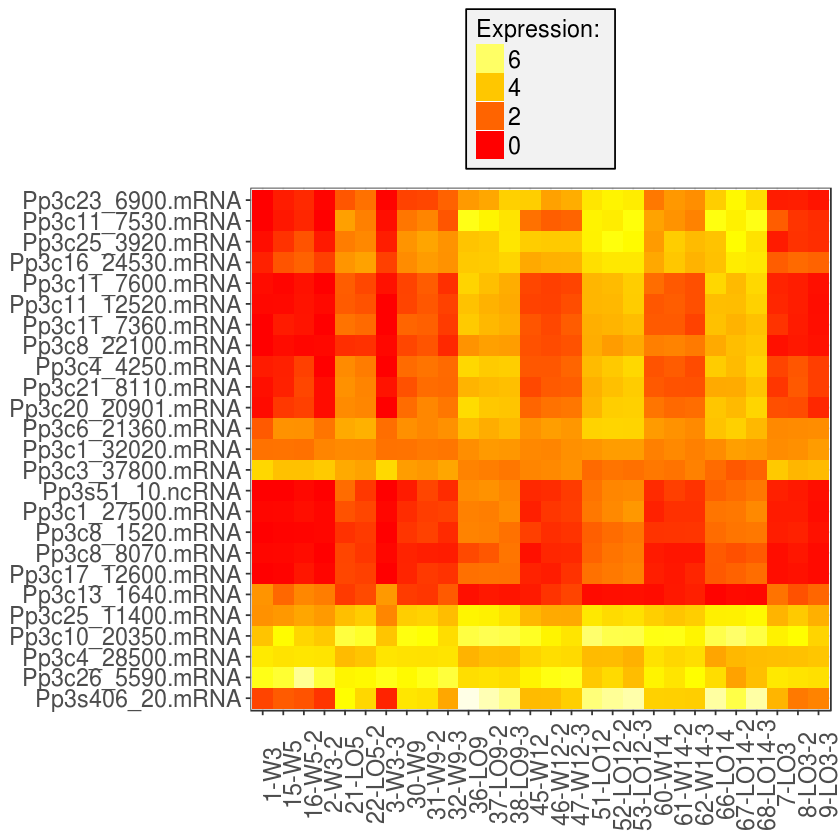

In [43]:
plot_transcript_heatmap(so.D, head(O, n = 25)$target_id)

In [44]:
subset(O,spectype=="pre_miRNA" & qval.lrt<0.1)[,c("target_id","test_stat","b","qval.lrt","qval.wt","Alias")]

,target_id,test_stat,b,qval.lrt,qval.wt,Alias
7099,Pp3c16_9758.pre_miRNA,18.31892,-0.5162184,0.0004605751,0.0003342759,"MI0003501,Pp3c16_9758N1.1,ppt-MIR534a,N1.Chr16.ncRNA.50,Pp3c16_9758V1.1"


In [ ]:
write.table(o,gzfile("comp.WT_vs_Loop/dge.tsv.gz"),sep="\t",col.names=TRUE,row.names=FALSE,quote=FALSE)
write.table(O,gzfile("comp.WT_vs_Loop/dge.full.tsv.gz"),sep="\t",col.names=TRUE,row.names=FALSE,quote=FALSE)